## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import plot_path, sample_sde
from path_sampling import dfdt, div_f, update_non_amortized




`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 2


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## 2D double well example

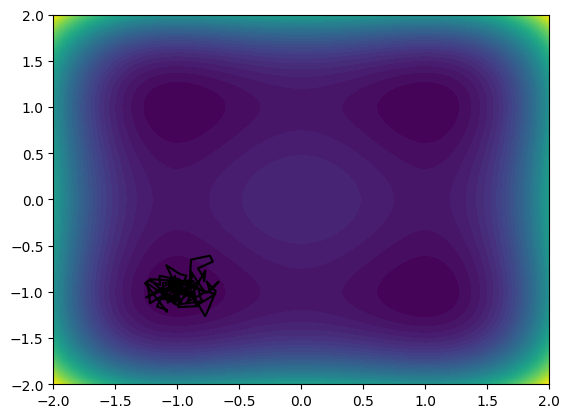

In [6]:


def make_double_well_potential_2D(v):
    def potential(x):
        # print(x.shape, "x shape")
        # return None
        """
        Double well potential
        """
    
        if x.shape != (2,):
            print(f"Expected shape (2,), got {x.shape}")
        assert x.shape == (2,)
        return jnp.sum(v*(x**2 - 1)**2, axis=-1)
    return potential

# make_double_well_potential_2D(v=1.0)(jnp.array([0.5, 0.5]))

def uref_2d(x,t):
    return -jax.grad(make_double_well_potential_2D(v=5.0))(x)

path, time = sample_sde(
    b=uref_2d,
    W=lambda x, key: jax.random.normal(key, shape=(2,)),
    rho=lambda key: jnp.zeros((2,))-1,
    dt=0.01,
    num_steps=100,
    key=jax.random.PRNGKey(0)
)



plot_path(path=path, time=time, potential=make_double_well_potential_2D(5.0), i=0, label="path")


We can then calculate a path cost `J(x)` as follows:

s:  0.0
Train loss: 6528354.0
Test loss is 5943004.0


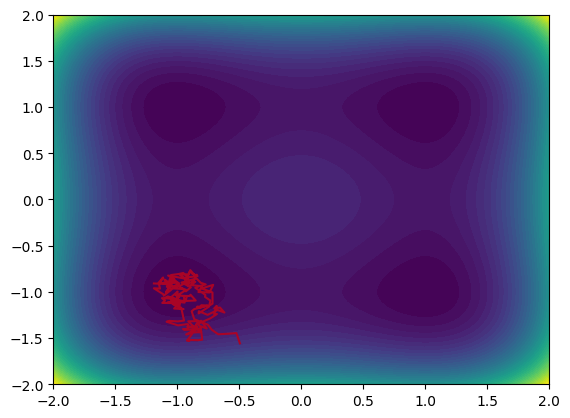

In [5]:


key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([6,20,20,2], key=jax.random.key(0))


# def I(x, time, uref):
#     x = x.reshape((-1, ndims))
#     dt = time[1]
#     dxdts = dfdt(x, dt)
#     div_us = div_f(x, time, uref)
#     out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
#     return jnp.sum(out)

b = uref_2d
A = 0
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=(lambda x, y: (1/0.1**2)*jnp.linalg.norm(x[-1]- np.array([1,1]))**2),
        V=make_double_well_potential_2D(v=1.0),
        # J=(lambda x, y: (1/0.1**2)*jnp.linalg.norm(x[-1]- np.array([1,1]))**2),
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 100, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        rho=lambda key: jnp.zeros((2,))-1.,
        ndims=2,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

s:  0.0
Train loss: 259927.203125
Test loss is 217775.09375
s:  0.1
Train loss: 325243.125
Test loss is 283817.625
s:  0.2
Train loss: 34489.64453125
Test loss is 43909.27734375
s:  0.3
Train loss: 70455.2109375
Test loss is 67381.0703125
s:  0.4
Train loss: 34352.76171875
Test loss is 48351.48046875
s:  0.5
Train loss: 29617.58984375
Test loss is 36568.65625
s:  0.6
Train loss: 33741.26953125
Test loss is 29373.849609375
s:  0.7
Train loss: 18042.91796875
Test loss is 25184.89453125
s:  0.8
Train loss: 36014.6015625
Test loss is 23898.548828125
s:  0.9
Train loss: 16278.791015625
Test loss is 23280.65234375


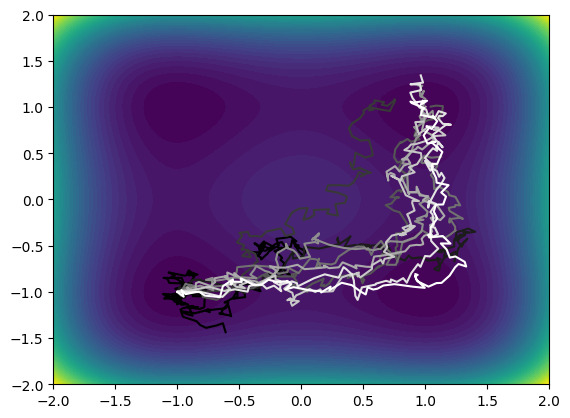

In [10]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([6,20,20,2], key=jax.random.key(0))

from path_sampling import dfdt, div_f, update_non_amortized

# def I(x, time, uref):
#     x = x.reshape((-1, ndims))
#     dt = time[1]
#     dxdts = dfdt(x, dt)
#     div_us = div_f(x, time, uref)
#     out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
#     return jnp.sum(out)

b = uref_2d
A = 0
for i, s in enumerate(schedule):




    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential_2D(1.0),
        b=b, # lambda x, t : jnp.array([0.0]),
        J=(lambda x, y: (1/(2*0.1**2))*(jnp.linalg.norm(x[-1]- np.array([1,1]))**2) + (1/(2*0.1**2))*jnp.linalg.norm(x[50]- np.array([1,-1]))**2),
        # J=(lambda x, y: (1/0.1**2)*jnp.linalg.norm(x[-1]- np.array([1,1]))**2),
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        rho=lambda key: jnp.zeros((2,))-1.,
        ndims=2
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

s:  0.0
Train loss: 265956.40625
Test loss is 218367.859375
s:  0.1
Train loss: 237207.65625
Test loss is 261867.46875
s:  0.2
Train loss: 91015.75
Test loss is 70796.2890625
s:  0.3
Train loss: 73349.703125
Test loss is 69820.5390625
s:  0.4
Train loss: 44118.37109375
Test loss is 44171.453125
s:  0.5
Train loss: 31434.611328125
Test loss is 33148.32421875
s:  0.6
Train loss: 46085.94140625
Test loss is 35273.72265625
s:  0.7
Train loss: 33050.50390625
Test loss is 25545.275390625
s:  0.8
Train loss: 29725.484375
Test loss is 20349.01953125
s:  0.9
Train loss: 23658.619140625
Test loss is 23518.794921875


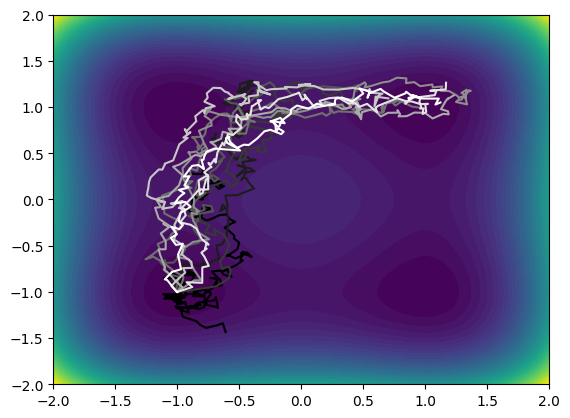